# Aplicações do Modelo Clássico de Regressão Linear

In [73]:
# Importando bibliotecas
import lmdiag
import numpy as np
import pandas as pd
import seaborn as sn
from patsy import dmatrices
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [74]:
# Leitura e definição de tipos da base de dados
df = pd.read_stata('salario_stata11.dta')

# Convertendo tipos e visualizando dados
df = df.astype({
    'Sal':          'int8',
    'Exp':          'int8',
    'CursoCap':     'int8',
    'DummyMulher':  'bool',
    'Posgrad':      'int8'
})
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Sal          10 non-null     int8 
 1   Exp          10 non-null     int8 
 2   CursoCap     10 non-null     int8 
 3   DummyMulher  10 non-null     bool 
 4   Posgrad      10 non-null     int8 
dtypes: bool(1), int8(4)
memory usage: 182.0 bytes


,Sal,Exp,CursoCap,DummyMulher,Posgrad
0,15,8,0,False,1
1,20,6,1,False,2
2,20,15,0,False,2
3,40,20,1,True,3
4,50,25,2,True,3
5,25,11,1,False,2
6,10,5,0,False,1
7,55,32,3,True,1
8,35,28,1,False,2
9,30,20,1,False,2


## Análise exploratória

In [75]:
# Estatísticas descritivas
describe_int8 = df.describe(include='int8')
rounded_df = describe_int8.round(2)
describe_dummy = df.describe(include='bool')

display(rounded_df)
print('====================')
display(describe_dummy)

,Sal,Exp,CursoCap,Posgrad
count,10.00,10.00,10.00,10.00
mean,30.00,17.00,1.00,1.90
std,14.91,9.51,0.94,0.74
min,10.00,5.00,0.00,1.00
25%,20.00,8.75,0.25,1.25
50%,27.50,17.50,1.00,2.00
75%,38.75,23.75,1.00,2.00
max,55.00,32.00,3.00,3.00


,DummyMulher
count,10
unique,2
top,False
freq,7


- 0 = False = Homem
- 1 = True  = Mulher

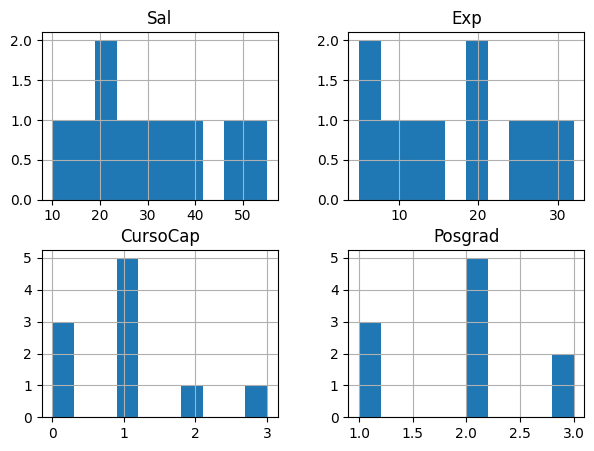

In [76]:
# Histograma
hist = df.hist(column=['Sal', 'Exp', 'CursoCap', 'Posgrad'], figsize=(7,5))

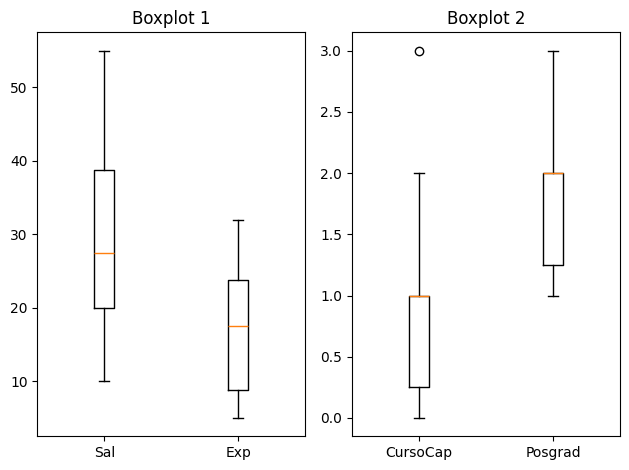

In [77]:
# Boxplot

# Criar subplots para colunas
fig, axes = plt.subplots(1, 2)

# Primeiro boxplot
axes[0].boxplot(df[['Sal', 'Exp']])
axes[0].set_title('Boxplot 1')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Sal', 'Exp'])

# Segundo boxplot
axes[1].boxplot(df[['CursoCap', 'Posgrad']])
axes[1].set_title('Boxplot 2')
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['CursoCap', 'Posgrad'])

plt.tight_layout()
plt.show()

## Modelo de regressão

In [78]:
# Ajuste e Resultados do modelo de regressão
fit = smf.ols('Sal ~ Exp + CursoCap + DummyMulher + Posgrad', data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    Sal   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     374.9
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           2.22e-06
Time:                        11:09:56   Log-Likelihood:                -12.146
No. Observations:                  10   AIC:                             34.29
Df Residuals:                       5   BIC:                             35.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.3996    

/home/herick/git/aplicacoes-MCRL/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [79]:
# Dados de exemplo
output = [
    ("Dep. Variable:", "Sal"),
    ("R-squared:", "0.997"),
    ("Model:", "OLS"),
    ("Adj. R-squared:", "0.994"),
    ("Method:", "Least Squares"),
    ("F-statistic:", "374.9")
]

# Formatar a saída
width = max(len(row[0]) for row in output) + 2  # Calcula o maior comprimento + 2 espaços extras
formatted_output = "\n".join(f"{row[0].ljust(width)}{row[1].rjust(10)}" for row in output)

# Imprime a saída formatada
print(formatted_output)


Dep. Variable:          Sal
R-squared:            0.997
Model:                  OLS
Adj. R-squared:       0.994
Method:          Least Squares
F-statistic:          374.9


O R2 ajustado de 94,4% indica que as variáveis independentes tem têm um forte poder explicativo sobre a variável dependente.

Considerando o nível de significância de 5%, pode-se rejeitar a hipótese nula do teste t para todas as variáveis. A rejeição de Ho indica que todas são significativas na explicação da variável dependente.

# Verificação dos pressupostos

## Teste de multicolinearidade

### Matriz de correlação

- 0 indica ausência de correlação linear entre as variáveis.
- 1 indica uma correlação perfeita.

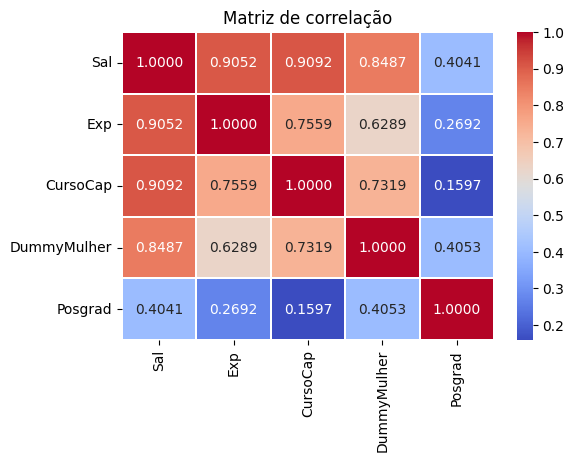

In [80]:
# Matriz de correlação
correlation = df.corr()

# plot da matriz de correlação
plt.figure(figsize=(6, 4))
plot = sn.heatmap(correlation, annot = True, fmt=".4f", linewidths=.1, cmap='coolwarm')
plt.title('Matriz de correlação')
plt.show()

### Análise dos Fatores de Inflação das Variâncias (VIF)

- VIF = 1 | Não correlacionados 
- 1 < VIF < 5 | Moderadamente correlacionados 
- VIF > 5 a 10 | Altamente correlacionados 

In [81]:
# Definindo o modelo para cálculo do VIF (Variance Inflation Factors)

# Ajustando a regressão para cálculo do VIF
y, X = dmatrices('Sal ~ Exp + CursoCap + DummyMulher + Posgrad', df, return_type='dataframe')

# Calculando VIF e adicionando em um DataFrame
vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["Fator VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Visualizar VIF das variáveis independentes
vif.loc[1:4].round(4)

,Variável,Fator VIF
1,DummyMulher[T.True],2.6561
2,Exp,2.4793
3,CursoCap,3.3908
4,Posgrad,1.2976


## Teste de Especificação do modelo

In [82]:
# Teste RESET (Ramsey Regression Equation Specification Error Test)
reset = dg.linear_reset(fit, power = 3)

print(f'F Static: {reset.statistic:0.04f}\n'
      f'P-value: {reset.pvalue:0.04f}\n' 
      f'df_denom: {int(reset.df_denom)}')

F Static: 0.0397
P-value: 0.9804
df_denom: 2


## Análise dos resíduos

Ferramentas utilizadas na verificação das suposições primárias do Modelo de Regressão Linear referente aos resíduos.

1) Linearidade: Gráfico de Residuals vs. Fitted

2) Normalidade dos resíduos: Teste Shapiro-Wilk e gráfico Normal Q-Q

3) Homoscedasticidade dos resíduos: Teste Breusch-Pagan e gráfico Scale-Location

4) Pontos influentes e de alavancagem: Gráfico Residuals vs. Leverage

5) Independência: Não foi analisado já que a base de dados não contém séries temporais.

In [83]:
# Geração dos resíduos e valores ajustados
residuals = fit.resid
fitted_values = fit.fittedvalues

### Pressuposto da Linearidade

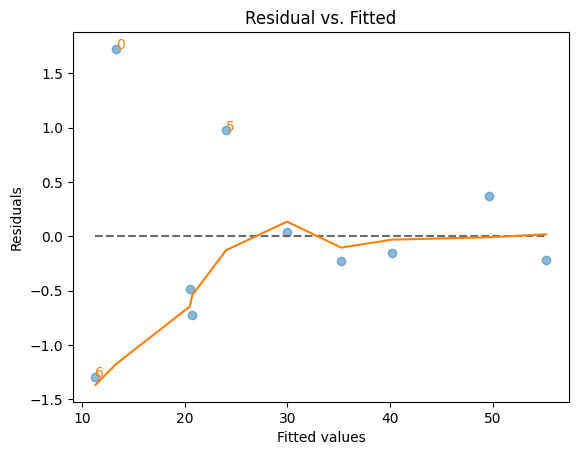

In [84]:
# Residuals vs. Fitted para Linearidade

lmdiag.resid_fit(fit);

### Pressuposto da Normalidade dos resíduos

In [85]:
# Normalidade dos Resíduos
# Teste de Shapiro-Wilk
shapiro_stat, shapiro_p_value = stats.shapiro(residuals)

print(f'Shapiro-Wilk static: {shapiro_stat.round(4)}\n'
      f'P-value Shapiro-Wilk static: {shapiro_p_value.round(4)}')

Shapiro-Wilk static: 0.9517
P-value Shapiro-Wilk static: 0.6887


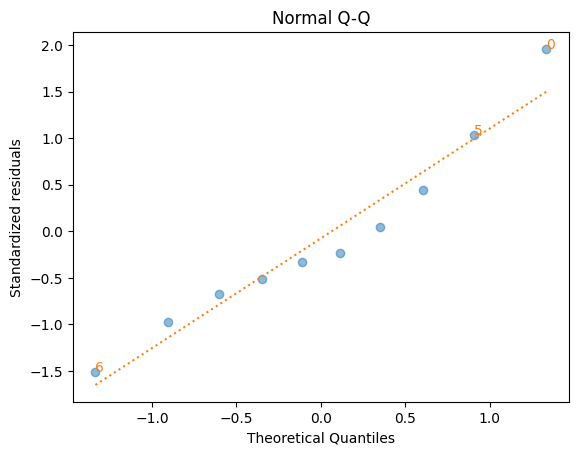

In [86]:
# Gráfico Normal Q-Q para linearidade

lmdiag.q_q(fit);

### Pressuposto da Homocedasticidade

Nível de significância de 5%

- Ho: o modelo é homocedástico
- H1: o modelo é heterocedástico

In [87]:
# Teste Breusch-Pagan (Teste de heterocedasticidade)

# Obter os resultados do teste
breusch_pagan = sms.het_breuschpagan(residuals, fit.model.exog)

print(f'Lagrange multiplier statistic: {breusch_pagan[0].round(4)}\n'
      f'P-value Lagrange static: {breusch_pagan[1].round(4)}')

Lagrange multiplier statistic: 7.2257
P-value Lagrange static: 0.1244


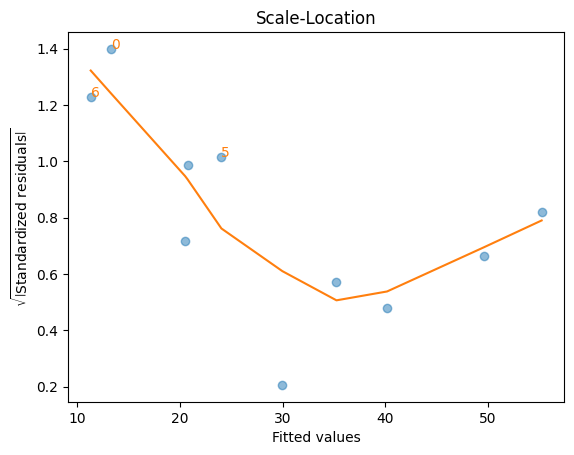

In [88]:
# Gráfico Scale-Location para Homocedasticidade

lmdiag.scale_loc(fit);

### Pontos influentes e de alavancagem

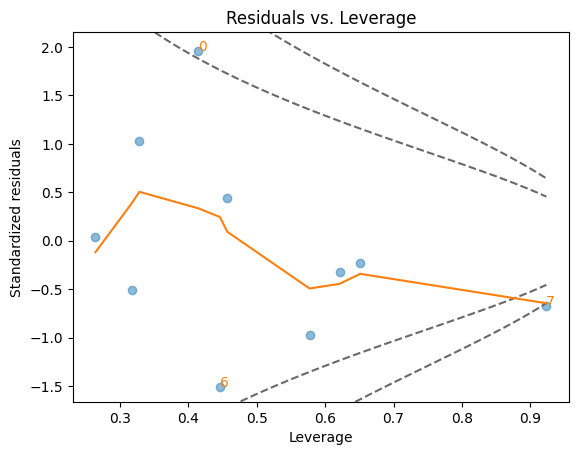

In [89]:
# Gráfico Residuals vs. Leverage para pontos influentes

lmdiag.resid_lev(fit);